<a href="https://colab.research.google.com/github/RafaelSdeSouza/astrostats-2025/blob/main/maze_Qlearn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Navigating Random Mazes with Breadth-First Search

This Colab notebook dives into the challenge of navigating through randomly generated mazes using the Breadth-First Search (BFS) algorithm. By generating mazes as grids of interconnected paths, we apply BFS to find the shortest possible route from a designated start point to a goal point. This approach demonstrates the power of classic graph traversal techniques in solving complex pathfinding problems.

## Overview of the Implementation

- **Maze Generation**: Our journey begins with the generation of a random maze. Each maze consists of a grid where cells are connected to their neighbors (up, down, left, right), forming a complex network of paths without loops, ensuring every part of the maze is reachable.

- **Solving with Breadth-First Search**: We employ the `breadth_first_search` function to navigate the maze. BFS explores the maze level by level, ensuring the discovery of the shortest path from the start to the goal due to its exhaustive nature.

## Key Concepts

- **Graph Theory in Mazes**: The maze is conceptually a graph where corridors represent edges, and intersections are nodes. BFS's application to this graph illustrates fundamental principles of graph theory and algorithmic problem-solving.

- **Algorithmic Efficiency**: This notebook also explores the efficiency of BFS in the context of maze navigation, discussing how it ensures the optimal solution and its implications on computational resources.

## Q-Learning for  Maze Navigation

In addition to employing Breadth-First Search for finding the shortest path, we also show Q-learning. Q-learning enables our agent to learn the value of taking specific actions in particular states, guiding it towards the goal through trial and error. By iteratively updating Q-values based on the rewards received for actions taken, the agent learns to optimize its path to the goal even in the absence of a predefined route. This approach not only showcases a fundamental RL technique but also contrasts algorithmic and learning-based strategies for maze navigation.


## Getting Started

Follow the provided steps to generate a maze and apply BFS for pathfinding. This process not only highlights algorithmic problem-solving strategies but also invites you to experiment with maze configurations and understand the underlying mechanics of graph traversal algorithms.



In [ ]:
from collections import deque, namedtuple
import gym
import numpy as np
import random

Edge = tuple
Tree = set
Maze = namedtuple('Maze', 'width, height, edges')

Square = tuple

def neighbors4(square) -> {Square}:
    """The 4 neighbors of an (x, y) square."""
    (x, y) = square
    return {(x + 1, y), (x - 1, y), (x, y + 1), (x, y - 1)}

def grid(width, height) -> {Square}:
    """All squares in a grid of these dimensions."""
    return {(x, y) for x in range(width) for y in range(height)}

def random_maze(width, height, pop=deque.pop) -> Maze:
    """Generate a random maze, using random_tree."""
    tree = random_tree(grid(width, height), neighbors4, pop)
    return Maze(width, height, tree)

def edge(A, B) -> Edge: return Edge(sorted([A, B]))

def random_tree(nodes, neighbors, pop=deque.pop) -> Tree:
    """Repeat: pop a node and add edge(node, nbr) until all nodes have been added to tree."""
    tree = Tree()
    nodes = set(nodes)
    root = nodes.pop()
    frontier = deque([root])
    while nodes:
        node = pop(frontier)
        nbrs = neighbors(node) & nodes
        if nbrs:
            nbr = random.choice(list(nbrs))
            tree.add(edge(node, nbr))
            nodes.remove(nbr)
            frontier.extend([node, nbr])
    return tree

class MazeEnv(gym.Env):
    def __init__(self, width, height):
        super(MazeEnv, self).__init__()

        # Generate the maze here
        self.maze = random_maze(width, height)

        # Define the start position
        self.start_position = (0, 0)
        self.goal_position = (width - 1, height - 1)  # assuming goal is at the top right corner

        # Define action and observation spaces
        self.action_space = gym.spaces.Discrete(4)
        self.observation_space = gym.spaces.Box(low=np.array([0, 0]), high=np.array([width - 1, height - 1]), dtype=np.int)

        # Create set of all passages
        self.passages = self.create_passages()

    def reset(self):
        self.state = self.start_position
        return self.state

    def step(self, action):
        # Initialize variables
        done = False
        reward = -1  # default reward
        next_state = list(self.state)

        # Update state
        if action == 0:  # up
            next_state[1] = max(next_state[1]-1, 0)
        elif action == 1:  # down
            next_state[1] = min(next_state[1]+1, self.maze.height-1)
        elif action == 2:  # left
            next_state[0] = max(next_state[0]-1, 0)
        elif action == 3:  # right
            next_state[0] = min(next_state[0]+1, self.maze.width-1)

        # Check if next state is valid
        if tuple(next_state) not in self.passages:
            next_state = self.state  # bounce back, make it impossible to hit a wall

        self.state = tuple(next_state)

        # Check if goal has been reached
        if self.state == self.goal_position:
            reward = 5000  # big reward when reaching the goal
            done = True

        return self.state, reward, done, {}

    def create_passages(self):
        passages = set()
        for edge in self.maze.edges:
            passages.add(edge[0])
            passages.add(edge[1])
        return passages




In [ ]:
# Create the environment
# Define maze parameters
width = 45  # width of the maze
height = 30  # height of the maze
start_position = (0, 0)  # start at the top-left corner
goal_position = (width-1, height-1)  # goal at the bottom-right corner

# Create the maze and its grid representation
maze = random_maze(width, height)

In [ ]:
import matplotlib.pyplot as plt

def plot_maze(maze, figsize=None, path=None):
    """Plot a maze by drawing lines between adjacent squares, except for pairs in maze.edges"""
    w, h  = maze.width, maze.height
    plt.figure(figsize=figsize or (w/5, h/5))
    plt.axis('off')
    plt.gca().invert_yaxis()
    exits = {edge((0, 0), (0, -1)), edge((w-1, h-1), (w-1, h))}
    edges = maze.edges | exits
    for sq in grid(w, h):
        for nbr in neighbors4(sq):
            if edge(sq, nbr) not in edges:
                plot_wall(sq, nbr)
    if path: # Plot the solution (or any path) as a red line through the maze
        X, Y = transpose((x + 0.5, y + 0.5) for (x, y) in path)
        plt.plot(X, Y, 'r-', linewidth=2)

def transpose(matrix): return list(zip(*matrix))

def plot_wall(s1, s2):
    """Plot a wall: a black line between squares s1 and s2."""
    (x1, y1), (x2, y2) = s1, s2
    if x1 == x2: # horizontal wall
        y = max(y1, y2)
        X, Y = [x1, x1+1], [y, y]
    else: # vertical wall
        x = max(x1, x2)
        X, Y = [x, x], [y1, y1+1]
    plt.plot(X, Y, 'k-', linewidth=2)

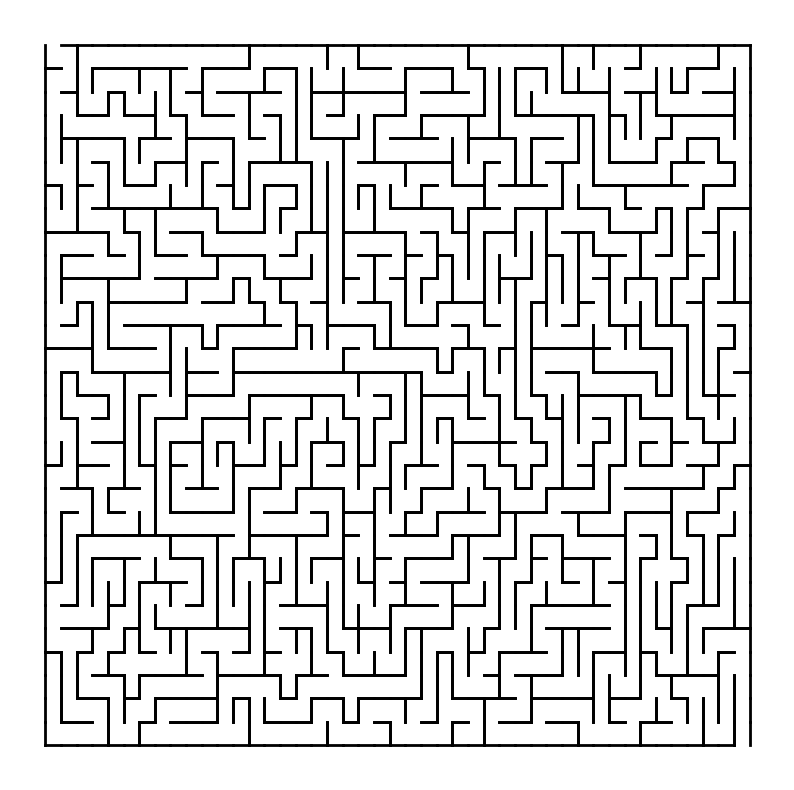

In [ ]:
plot_maze(maze, figsize=(10, 10))

In [ ]:
def breadth_first_search(maze):
    """Find a shortest sequence of states from start to the goal."""
    start = (0, 0)
    goal = (maze.width - 1, maze.height - 1)
    frontier = deque([start])  # A queue of states to consider
    paths = {start: [start]}   # start has a one-square path
    while frontier:
        s = frontier.popleft()
        if s == goal:
            return paths[s]
        for s2 in neighbors4(s):
            if s2 not in paths and edge(s, s2) in maze.edges:
                frontier.append(s2)
                paths[s2] = paths.get(s, []) + [s2]

In [ ]:
solution = breadth_first_search(maze)
solution

[(0, 0),
 (1, 0),
 (1, 1),
 (0, 1),
 (0, 2),
 (1, 2),
 (1, 3),
 (2, 3),
 (3, 3),
 (4, 3),
 (5, 3),
 (5, 4),
 (5, 5),
 (6, 5),
 (6, 4),
 (7, 4),
 (8, 4),
 (8, 3),
 (7, 3),
 (7, 2),
 (7, 1),
 (6, 1),
 (6, 2),
 (5, 2),
 (5, 1),
 (4, 1),
 (3, 1),
 (3, 2),
 (2, 2),
 (2, 1),
 (2, 0),
 (3, 0),
 (4, 0),
 (5, 0),
 (6, 0),
 (7, 0),
 (8, 0),
 (9, 0),
 (9, 1),
 (8, 1),
 (8, 2),
 (9, 2),
 (9, 3),
 (10, 3),
 (11, 3),
 (12, 3),
 (12, 2),
 (11, 2),
 (10, 2),
 (10, 1),
 (11, 1),
 (12, 1),
 (13, 1),
 (13, 0),
 (14, 0),
 (15, 0),
 (16, 0),
 (17, 0),
 (17, 1),
 (18, 1),
 (18, 0),
 (19, 0),
 (19, 1),
 (20, 1),
 (21, 1),
 (22, 1),
 (22, 0),
 (23, 0),
 (24, 0),
 (25, 0),
 (26, 0),
 (26, 1),
 (27, 1),
 (27, 2),
 (26, 2),
 (25, 2),
 (24, 2),
 (23, 2),
 (23, 3),
 (22, 3),
 (21, 3),
 (21, 4),
 (22, 4),
 (23, 4),
 (24, 4),
 (25, 4),
 (25, 3),
 (26, 3),
 (26, 4),
 (26, 5),
 (27, 5),
 (27, 4),
 (28, 4),
 (29, 4),
 (29, 5),
 (28, 5),
 (28, 6),
 (29, 6),
 (30, 6),
 (31, 6),
 (32, 6),
 (32, 5),
 (31, 5),
 (31, 4),
 (3

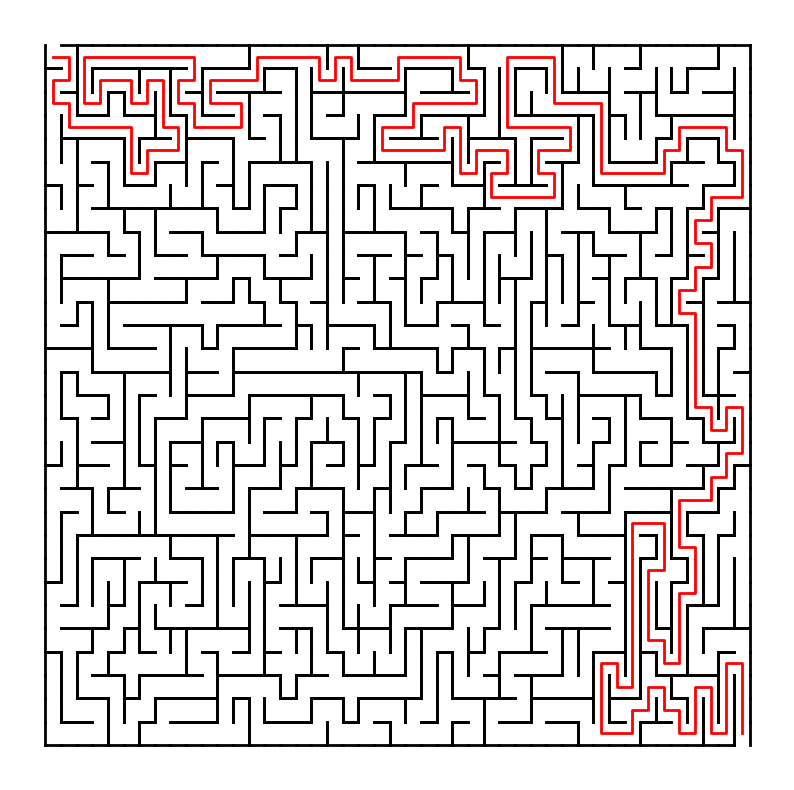

In [ ]:
plot_maze(maze, figsize=(10, 10), path=solution)

In [ ]:
import random

# Function to get available actions for a given state
def get_available_actions(state, maze):
    actions = []
    for action in neighbors4(state):
        if edge(state, action) in maze.edges:
            actions.append(action)
    return actions

# Function to select the best action based on Q-values (with epsilon-greedy policy)
def select_action(state, q_values, epsilon):
    if random.random() < epsilon:
        return random.choice(get_available_actions(state, maze))
    else:
        return max(get_available_actions(state, maze), key=lambda a: q_values.get((state, a), 0))

# Function to update Q-values based on the Q-learning update rule
def update_q_value(state, action, next_state, reward, q_values, alpha, gamma):
    max_next_q = max(q_values.get((next_state, next_action), 0) for next_action in get_available_actions(next_state, maze))
    current_q = q_values.get((state, action), 0)
    new_q = current_q + alpha * (reward + gamma * max_next_q - current_q)
    q_values[(state, action)] = new_q

In [ ]:
# Q-learning function to find a solution to the maze
def q_learning(maze, num_episodes=1000, alpha=0.1, gamma=0.9, epsilon=0.1):
    q_values = {}
    goal = (maze.width - 1, maze.height - 1)

    for _ in range(num_episodes):
        state = (0, 0)
        path = [state]

        while state != goal:
            action = select_action(state, q_values, epsilon)
            next_state = action
            reward = 1 if next_state == goal else -1  # Positive reward at the goal state, negative otherwise

            update_q_value(state, action, next_state, reward, q_values, alpha, gamma)

            state = next_state
            path.append(state)

    return path


In [ ]:
# Running the Q-learning algorithm
num_episodes = 1000
alpha = 0.1
gamma = 0.9
epsilon = 0.1

solution_path = q_learning(maze, num_episodes, alpha, gamma, epsilon)

# Print the solution path
print("Solution Path:", solution_path)

Solution Path: [(0, 0), (1, 0), (0, 0), (1, 0), (1, 1), (0, 1), (0, 2), (1, 2), (1, 3), (1, 2), (1, 3), (2, 3), (1, 3), (2, 3), (3, 3), (2, 3), (3, 3), (4, 3), (3, 3), (4, 3), (5, 3), (5, 4), (5, 5), (6, 5), (6, 4), (7, 4), (8, 4), (8, 3), (8, 4), (8, 3), (7, 3), (7, 2), (7, 3), (7, 2), (7, 1), (6, 1), (7, 1), (7, 2), (7, 1), (6, 1), (6, 2), (5, 2), (5, 1), (5, 2), (5, 1), (5, 2), (6, 2), (6, 1), (6, 2), (5, 2), (6, 2), (5, 2), (5, 1), (4, 1), (5, 1), (4, 1), (3, 1), (4, 1), (3, 1), (3, 2), (2, 2), (2, 1), (2, 2), (3, 2), (2, 2), (2, 1), (2, 0), (2, 1), (2, 0), (3, 0), (2, 0), (3, 0), (4, 0), (3, 0), (4, 0), (5, 0), (6, 0), (7, 0), (6, 0), (7, 0), (8, 0), (9, 0), (9, 1), (8, 1), (9, 1), (8, 1), (9, 1), (8, 1), (8, 2), (8, 1), (8, 2), (9, 2), (9, 3), (10, 3), (11, 3), (12, 3), (11, 3), (10, 3), (9, 3), (10, 3), (11, 3), (12, 3), (12, 2), (11, 2), (10, 2), (10, 1), (11, 1), (12, 1), (11, 1), (10, 1), (10, 2), (11, 2), (10, 2), (10, 1), (11, 1), (12, 1), (13, 1), (13, 0), (14, 0), (13, 0)

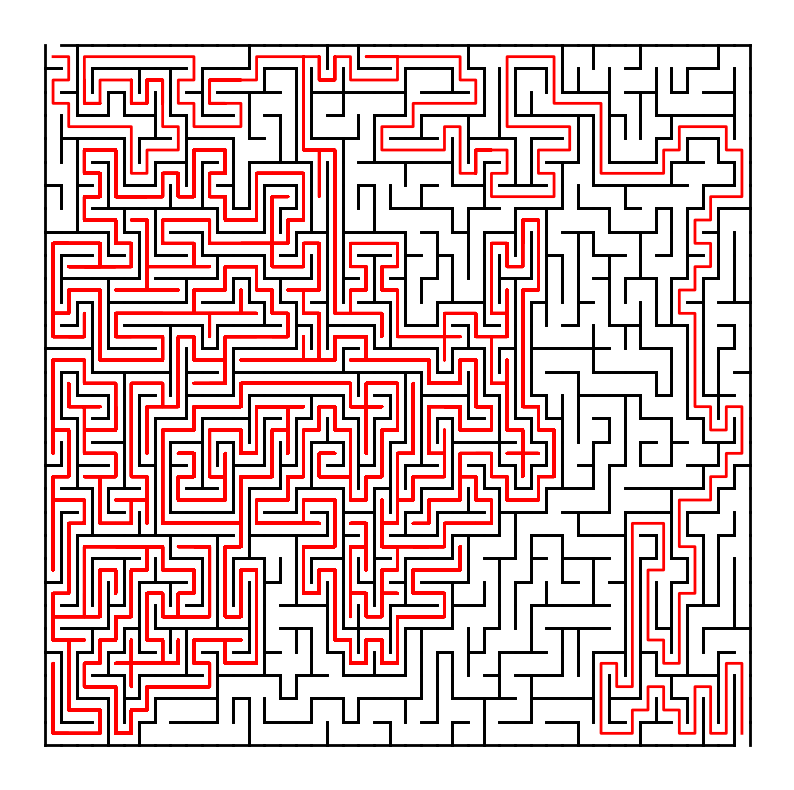

In [ ]:
plot_maze(maze, figsize=(10, 10), path=solution_path)